# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
import sys
from io import StringIO
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
train_data = pd.read_csv('../Datasets/train_V2.csv')

# Data Fields
DBNOs - Number of enemy players knocked.

assists - Number of enemy players this player damaged that were killed by teammates.

boosts - Number of boost items used.

damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

headshotKills - Number of enemy players killed with headshots.

heals - Number of healing items used.

Id - Player’s Id

killPlace - Ranking in match of number of enemy players killed.

killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

killStreaks - Max number of enemy players killed in a short amount of time.

kills - Number of enemy players killed.

longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

matchDuration - Duration of match in seconds.

matchId - ID to identify match. There are no matches that are in both the training and testing set.

matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

revives - Number of times this player revived teammates.

rideDistance - Total distance traveled in vehicles measured in meters.

roadKills - Number of kills while in a vehicle.

swimDistance - Total distance traveled by swimming measured in meters.

teamKills - Number of times this player killed a teammate.

vehicleDestroys - Number of vehicles destroyed.

walkDistance - Total distance traveled on foot measured in meters.

weaponsAcquired - Number of weapons picked up.

winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

numGroups - Number of groups we have data for in the match.

maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

# Data Analysis, Cleansing, Engineering, Pre-Processing

### View the dataset

In [60]:
train_data

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.000,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.040,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.000,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.000,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.000,0,0,49.75,2,0,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00,0,0,0,74,...,0,1292.0000,0,0.000,0,0,1019.00,3,1507,0.1786
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15,0,0,0,69,...,0,0.0000,0,0.000,0,0,81.70,6,0,0.2935
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06,0,0,0,66,...,0,0.0000,0,2.184,0,0,788.70,4,0,0.4815
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.40,1,1,2,11,...,2,0.0000,0,0.000,0,0,2748.00,8,0,0.8000


### Check column names, data types

In [61]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### Check missing values

In [62]:
is_NaN = train_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = train_data[row_has_NaN]
rows_with_NaN

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


#### Data Cleansing 1
Delete Missing Value, Ids

In [3]:
def delete_useless_data(train_data):
    train_data_ = train_data.copy()
    train_data_ = train_data_.drop(["Id","groupId","matchId"],axis=1)
    train_data_ = train_data_.drop(2744604)
    y_train = train_data_["winPlacePerc"]
    X_train = train_data_.drop(["winPlacePerc"],axis=1)
    return X_train,y_train,train_data_

In [4]:
X_train,y_train,train = delete_useless_data(train_data)

### Feature Plotting 

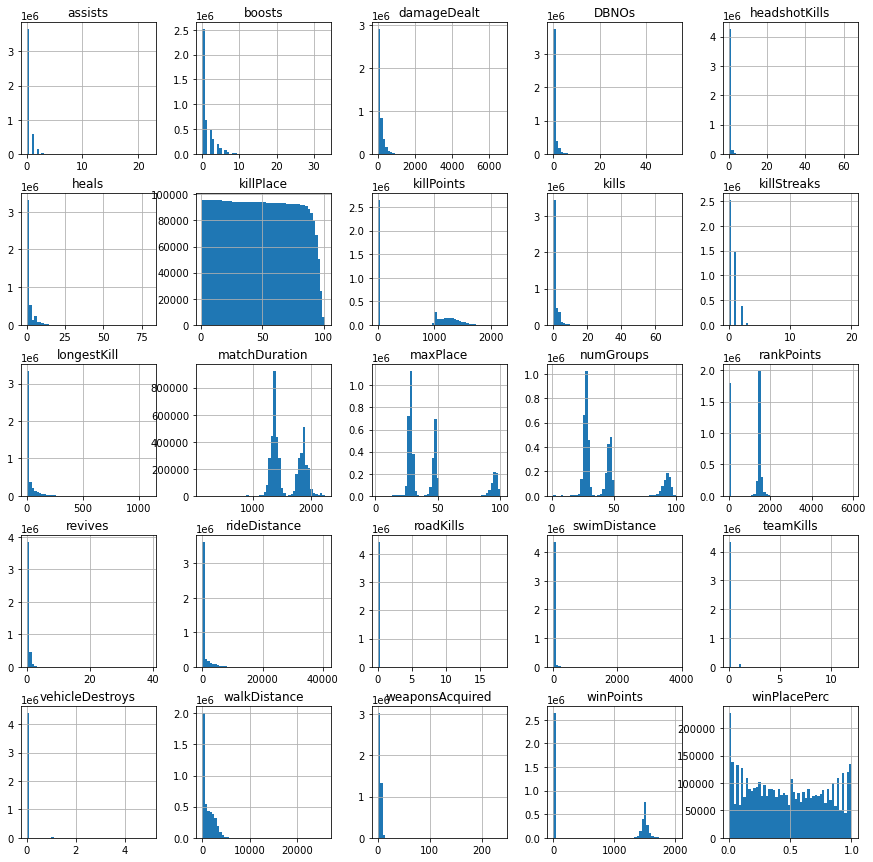

In [9]:
train.hist(bins=50, layout=(5,5),figsize=(15, 15))
plt.show()

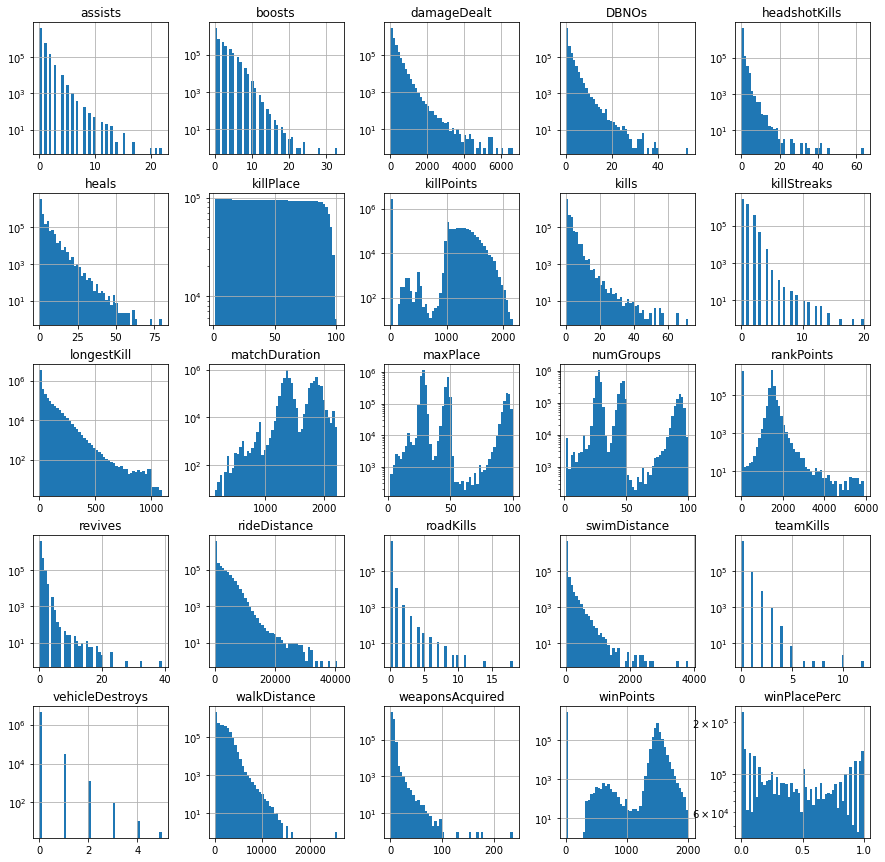

In [8]:
#Log scale
train.hist(bins=50, layout=(5,5),figsize=(15, 15),log=True)
plt.show()

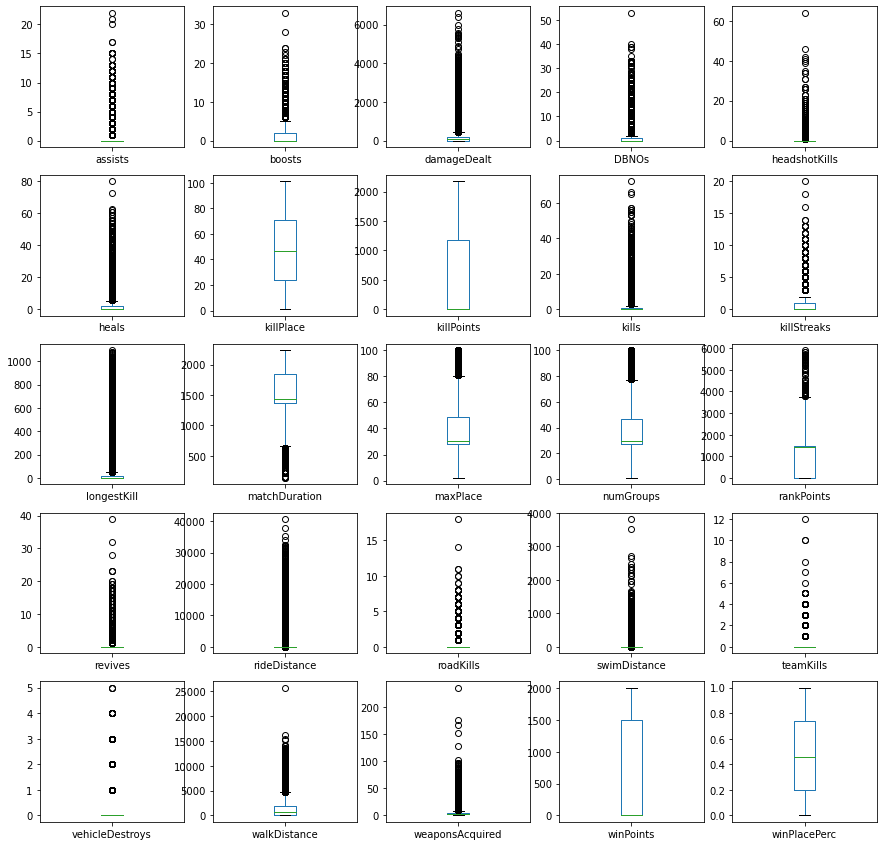

In [66]:
train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(15, 15))
plt.show()

### Data Normalization 
Min-Max Normalization

In [11]:
def normalize_data(dataset):
    dataset_ = dataset.copy()
    dataset_quantitative = dataset_.loc[:, dataset_.columns != 'matchType']
    for feature in dataset_quantitative:
        dataset_[feature]=(dataset_[feature]-dataset_[feature].min())/(dataset_[feature].max()-dataset_[feature].min())
    return dataset_

In [12]:
X_train = normalize_data(X_train)

### Cluster Analysis

In [16]:
def getAverageWPP(y,n_clusters):
    means = [0]*n_clusters
    for i in range(n_clusters):
        means[i] = y[y["cluster"] == i]["Y"].mean()
    return means

In [17]:
#One hot encoding
X_train_temp = pd.get_dummies(data = X_train, columns = ["matchType"])
kmeans = KMeans(random_state=200)

In [18]:
scores = []
Xs = []

In [19]:
best_n_clusters = 0
best_score = 0
best_average_Wpp = 0
for i in range(2,21):   
    kmeans.n_clusters = i
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp = pd.DataFrame({"Y": y_train})
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,i)
    if(score>best_score):
        best_score = score
        best_n_clusters = i
        best_average_Wpp = average_Wpp
    print("n_clusters: ",i,",Score: ",score, ",Average WPP: ",average_Wpp)
    Xs.append(i)
    scores.append(score)
    X_train_temp=X_train_temp.drop(["cluster"],axis=1) 

print("best_n_clusters: ",best_n_clusters,", best_score: ", best_score,", best_average_Wpp: ",best_average_Wpp)

n_clusters:  2 ,Score:  2410977.682043481 ,Average WPP:  [0.43562774382817704, 0.7499059023265002]
n_clusters:  3 ,Score:  3347262.8352789194 ,Average WPP:  [0.44574256816865865, 0.4364652158695649, 0.7529831016192975]
n_clusters:  4 ,Score:  3716196.9001603206 ,Average WPP:  [0.3826432740486614, 0.3202810215096796, 0.7425571593122683, 0.8201341144603471]
n_clusters:  5 ,Score:  3956693.1525134463 ,Average WPP:  [0.7820074366931732, 0.2987599518874195, 0.7420829304720569, 0.2972824260039439, 0.7853699338052667]
n_clusters:  6 ,Score:  4081617.6191062876 ,Average WPP:  [0.7887607859244876, 0.29465227578860287, 0.7747921977147817, 0.2977057324650074, 0.7161855323003286, 0.7859326793350533]
n_clusters:  7 ,Score:  4039099.2414899585 ,Average WPP:  [0.7898452227932578, 0.7863138704695876, 0.7165204750290067, 0.293524913292235, 0.7165459698012657, 0.7767337506901817, 0.2953351679431991]
n_clusters:  8 ,Score:  3947556.7809104244 ,Average WPP:  [0.29467034123960517, 0.25530500726794786, 0.85

#### View the scores with different clusters 

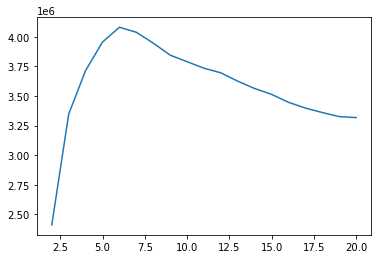

In [20]:
plt.plot(Xs,scores)

#### View the distribution for different cluster numbers
n_cluster = 2 and n_cluster = 6

n_cluster = 2 for investigating exactly the two different types

n_cluster = 6 for investigating the case with the best clustering performance

In [48]:
def plot_distributions(X_train_temp,y_train_temp,n_clusters):
    X_train_temp = X_train_temp.copy()
    y_train_temp = y_train_temp.copy()
    
    kmeans.n_clusters = n_clusters
    kmeans.fit(X_train_temp)
    score = metrics.calinski_harabasz_score(X_train_temp,kmeans.labels_)
    X_train_temp["cluster"] = kmeans.labels_
    y_train_temp = pd.DataFrame({"Y": y_train})
    y_train_temp["cluster"] = kmeans.labels_
    average_Wpp = getAverageWPP(y_train_temp,n_clusters)
    for n in range(n_clusters):
        X_temp_train = X_train_temp[X_train_temp["cluster"] == n]
        X_temp_train=X_temp_train.drop(["cluster"],axis=1) 
        y_temp_train = y_train_temp[y_train_temp["cluster"]==n]
        y_temp_train = y_temp_train.drop(["cluster"],axis=1) 
        temp_train = pd.concat([X_temp_train,y_temp_train],axis=1)
        temp_train.hist(bins=50, layout=(6,7),figsize=(15, 15),log=True)
        plt.suptitle("Average Wpp = "+str(average_Wpp[n]))
        plt.show()
        temp_train.plot(kind='box', subplots=True, layout=(6,7), sharex=False, sharey=False, figsize=(15, 15))
        plt.suptitle("Average Wpp = "+str(average_Wpp[n]))
        plt.show()

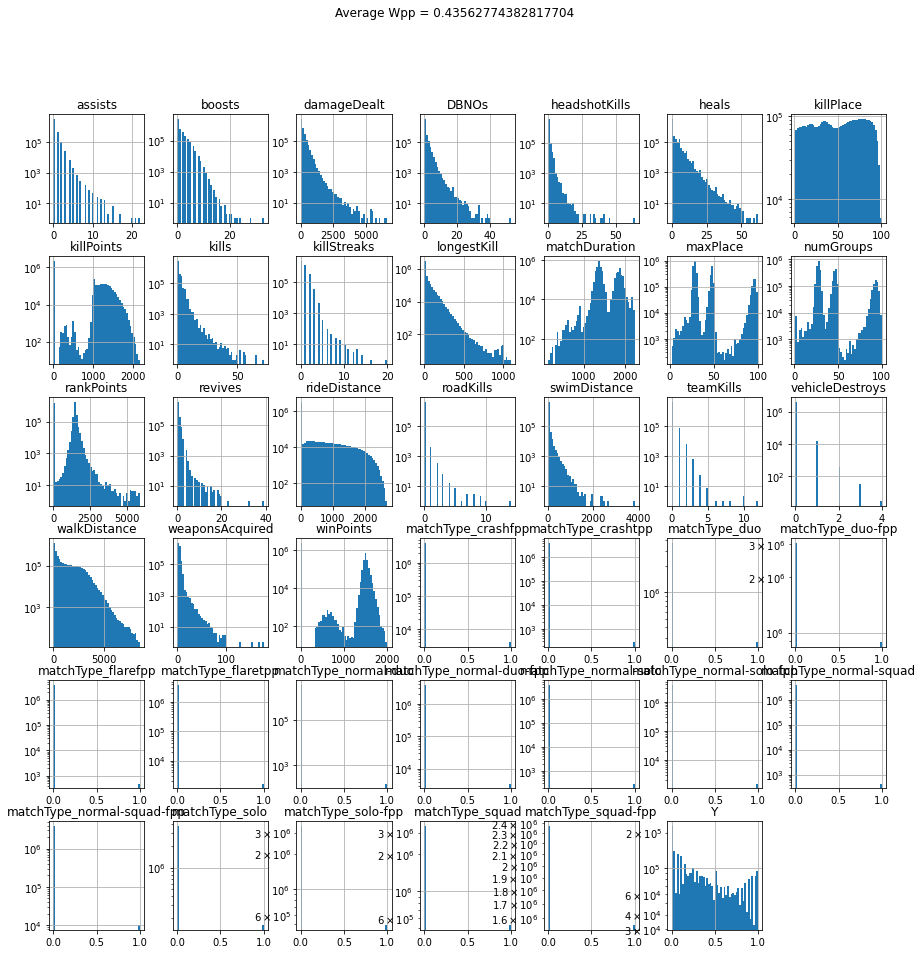

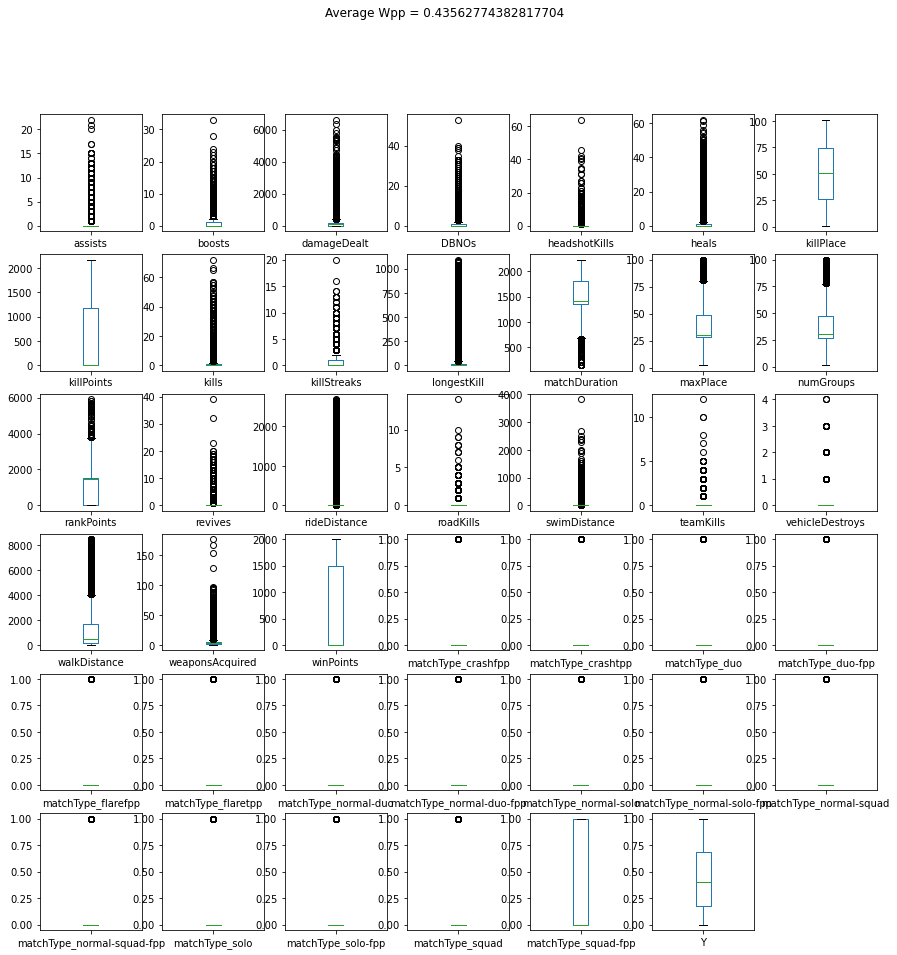

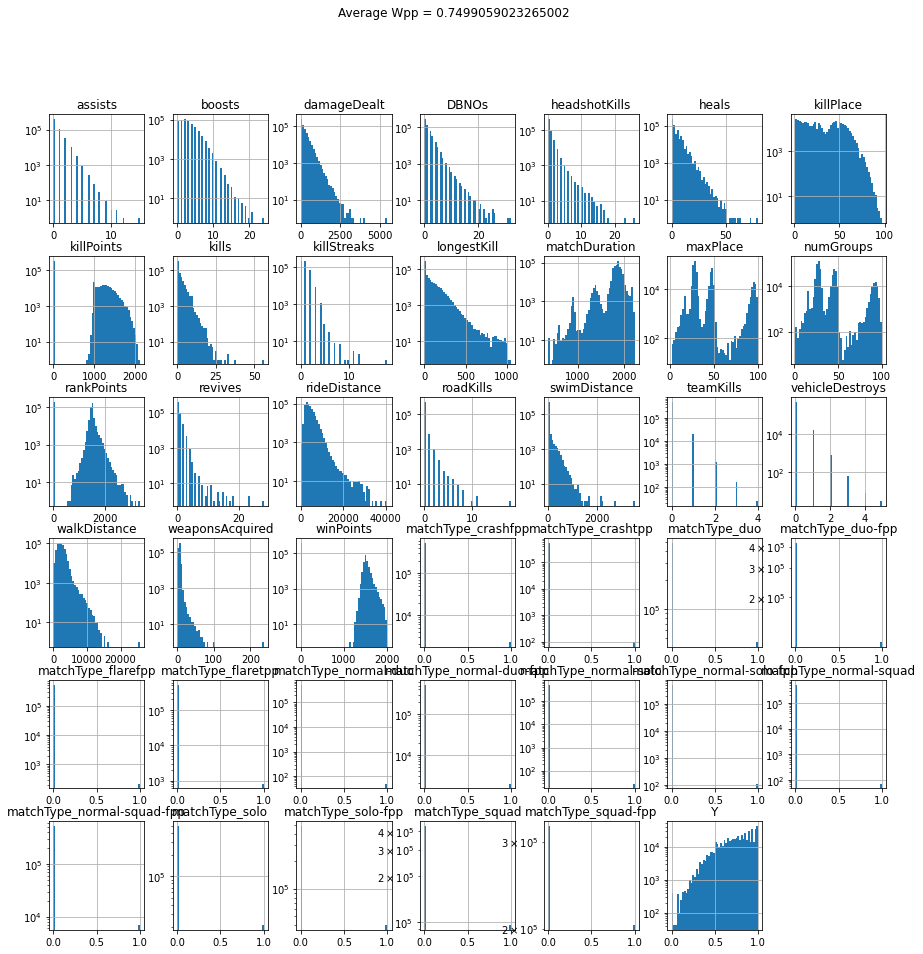

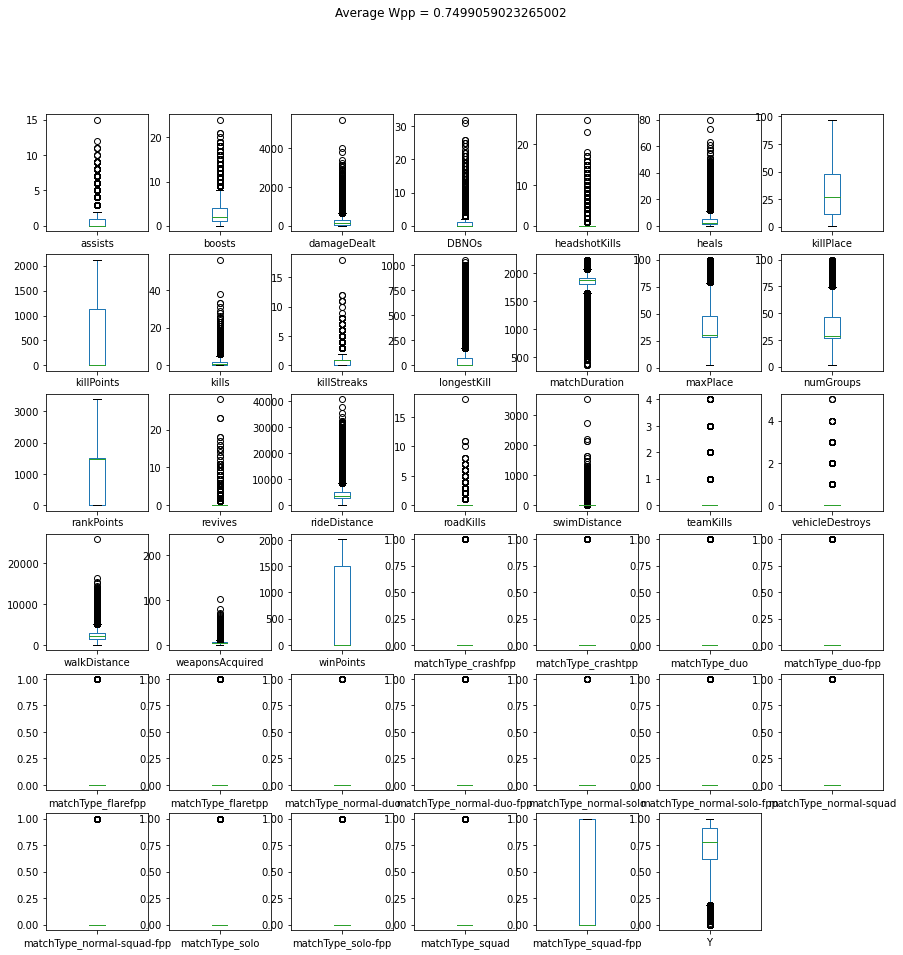

In [49]:
plot_distributions(X_train_temp,y_train_temp,2)

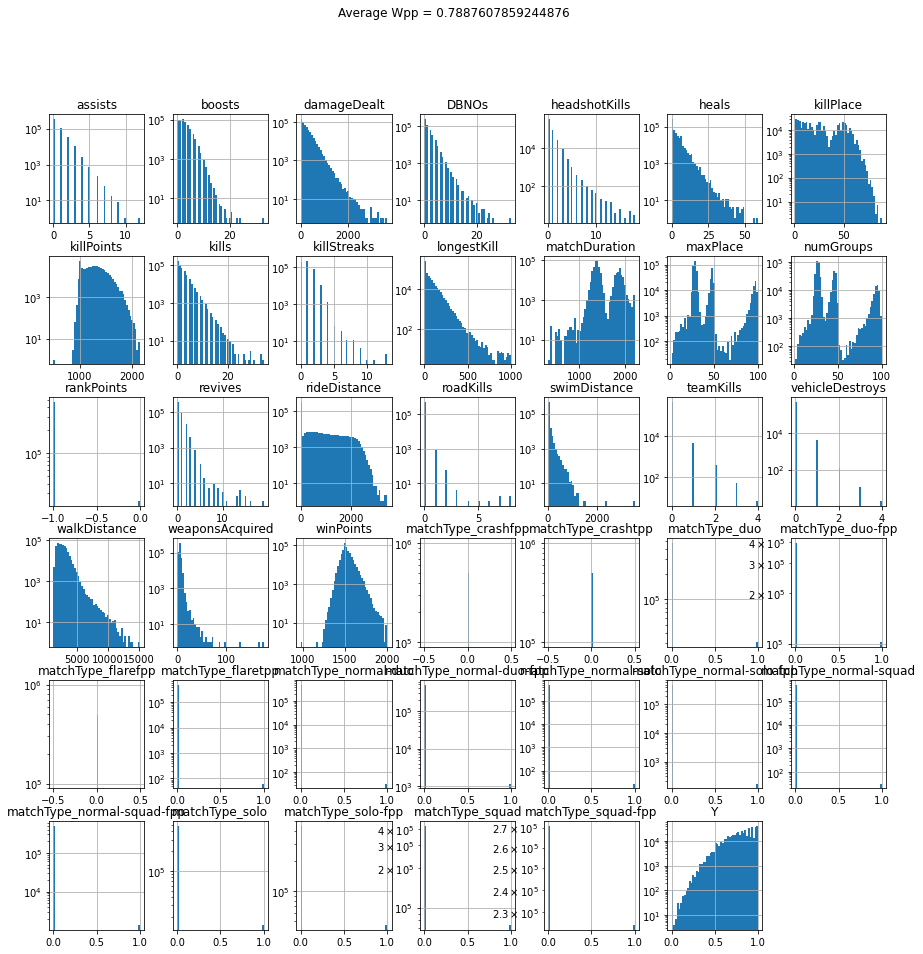

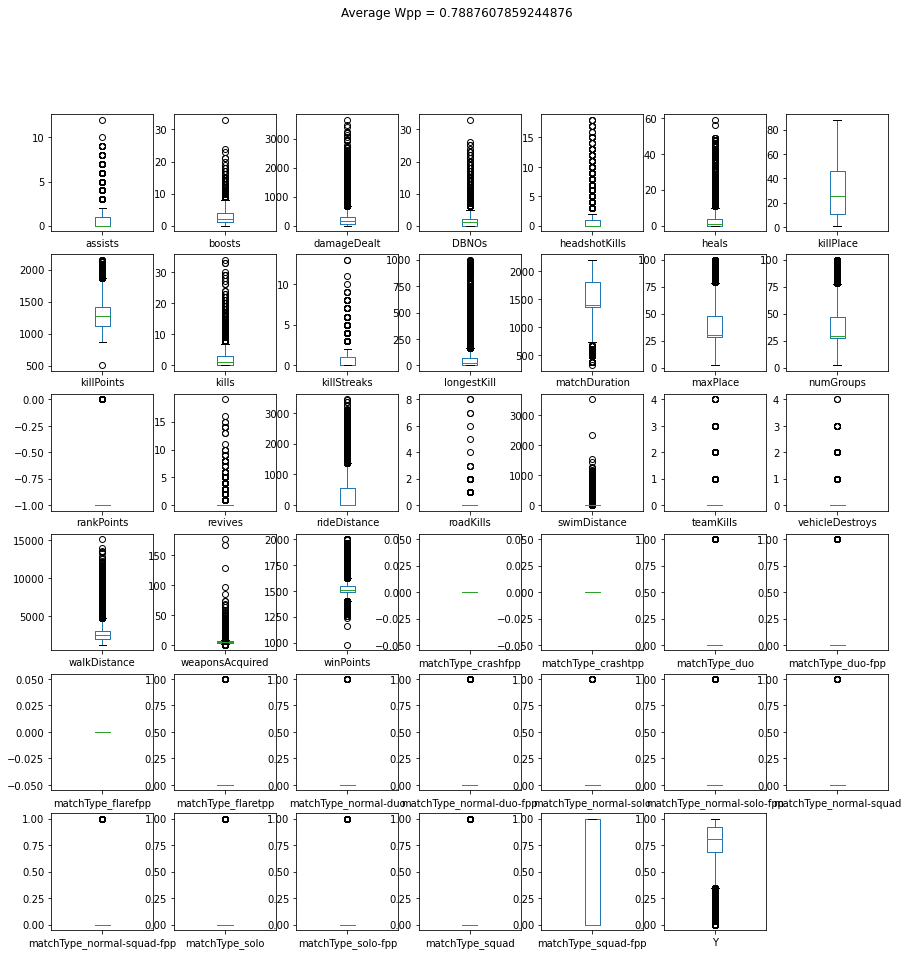

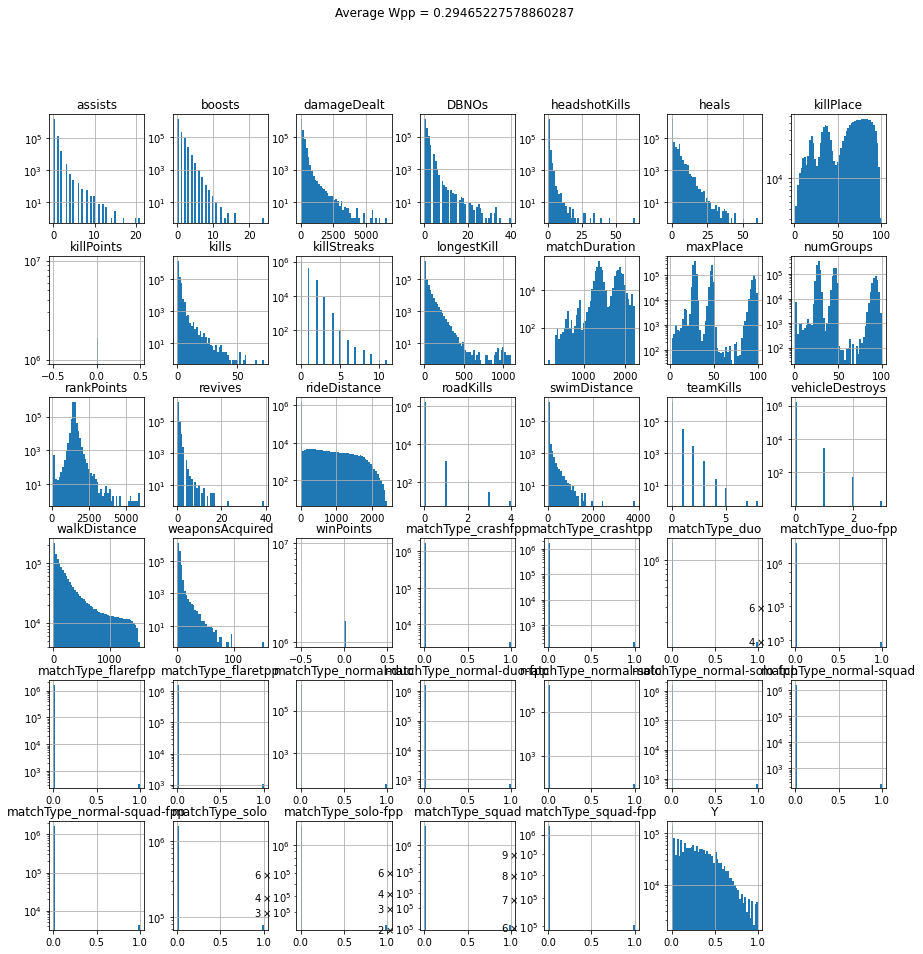

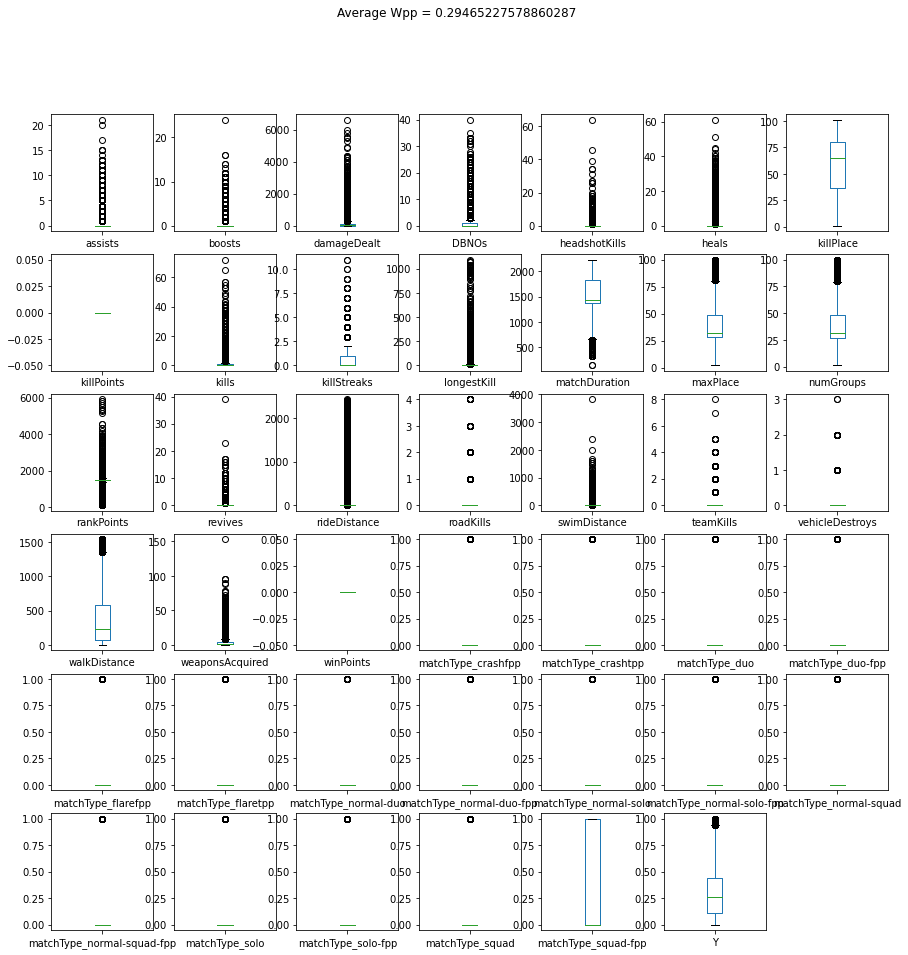

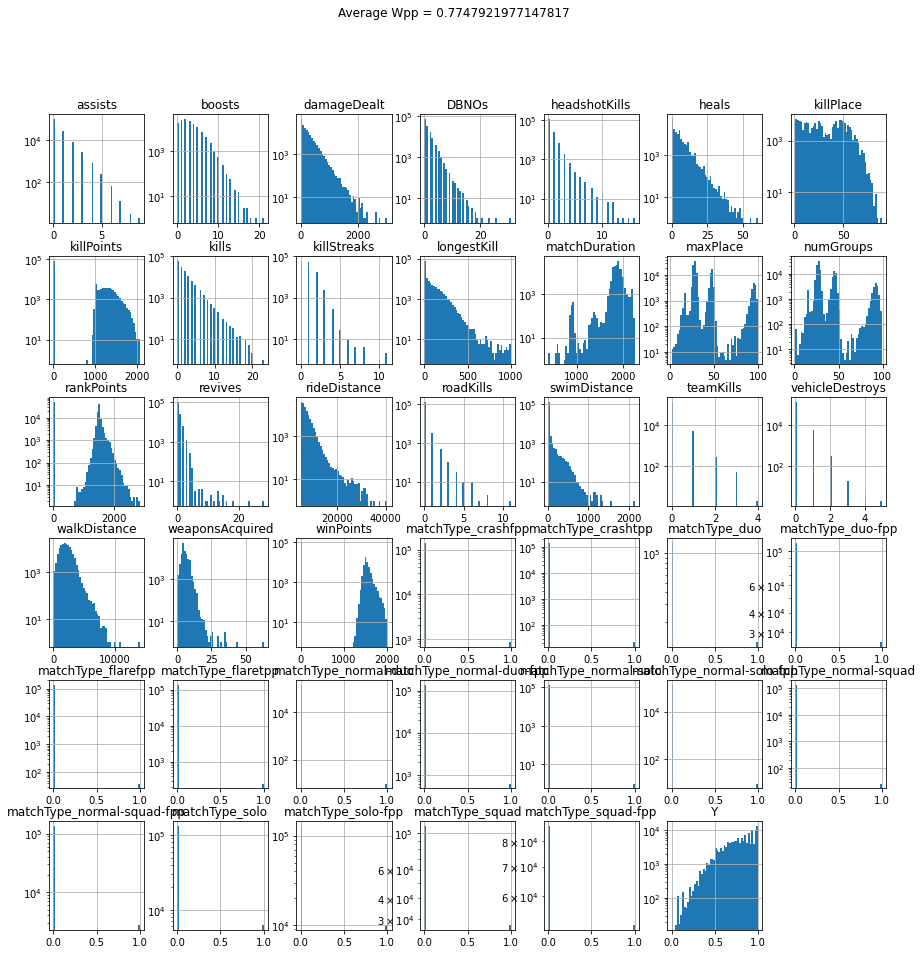

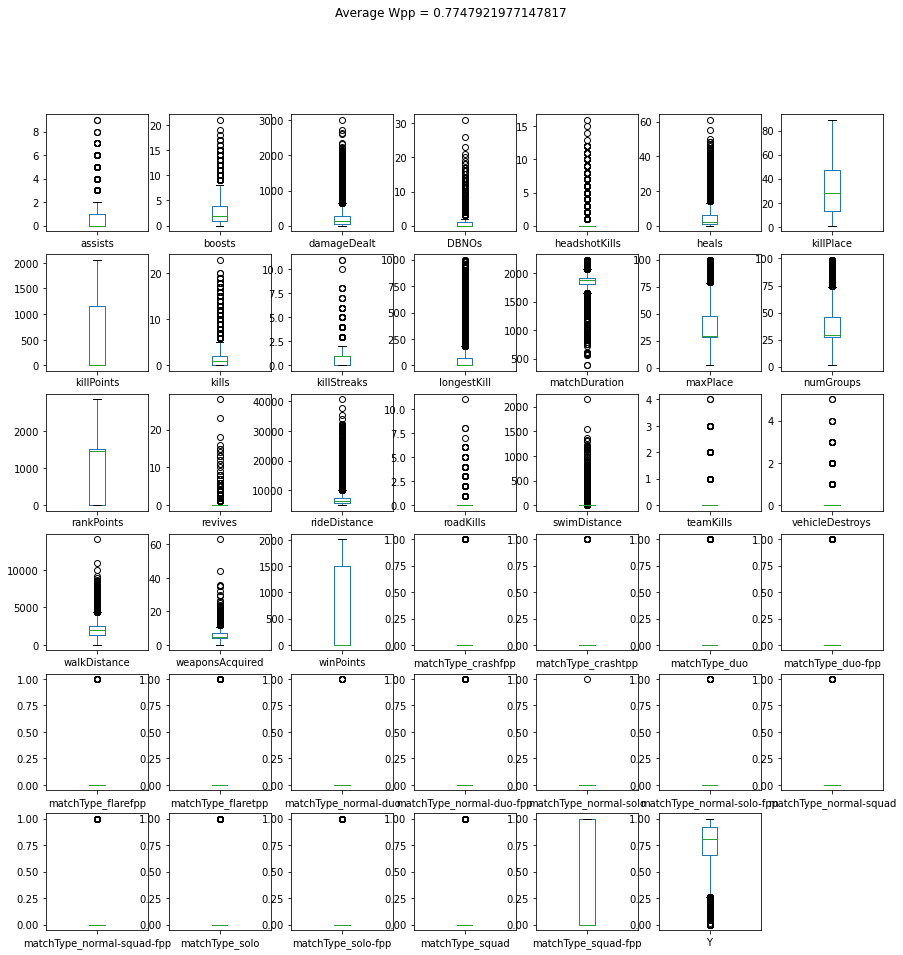

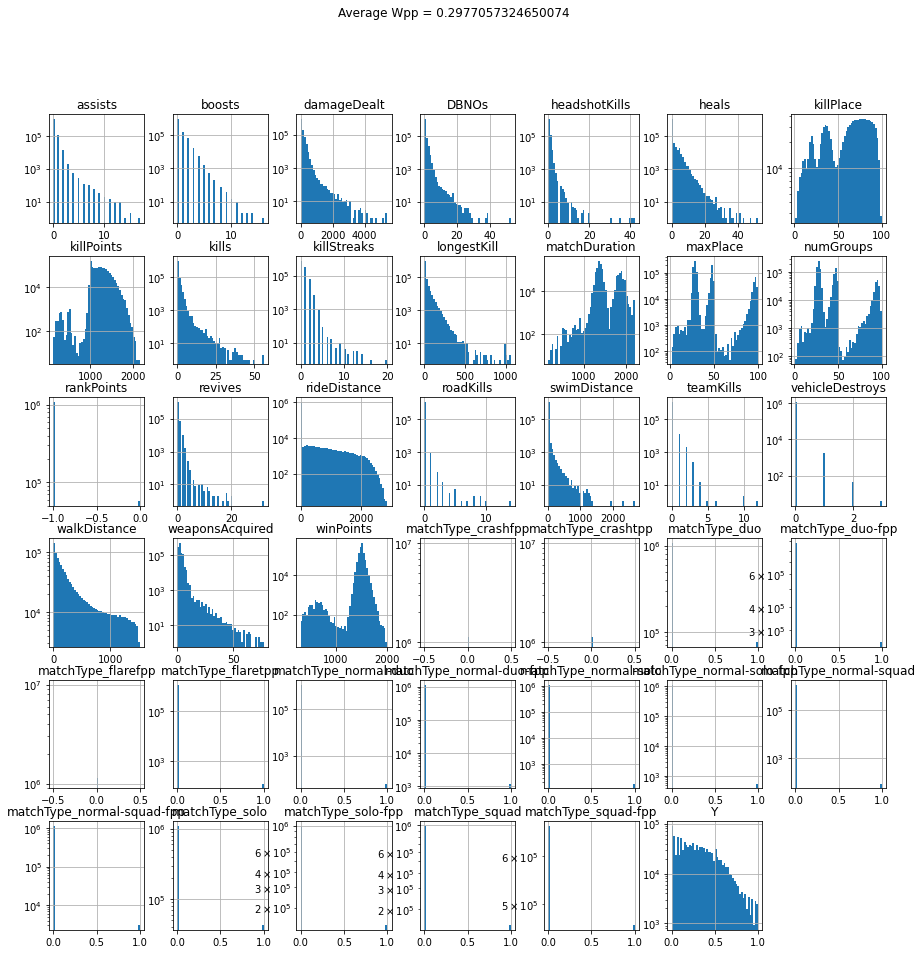

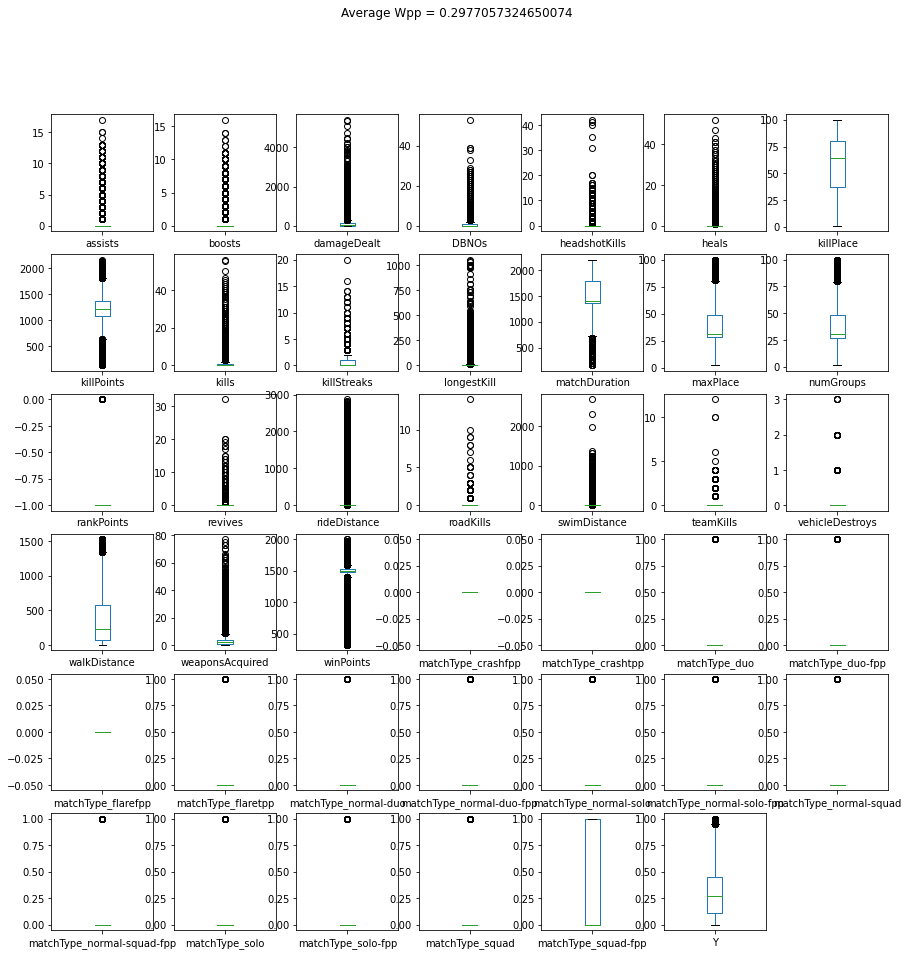

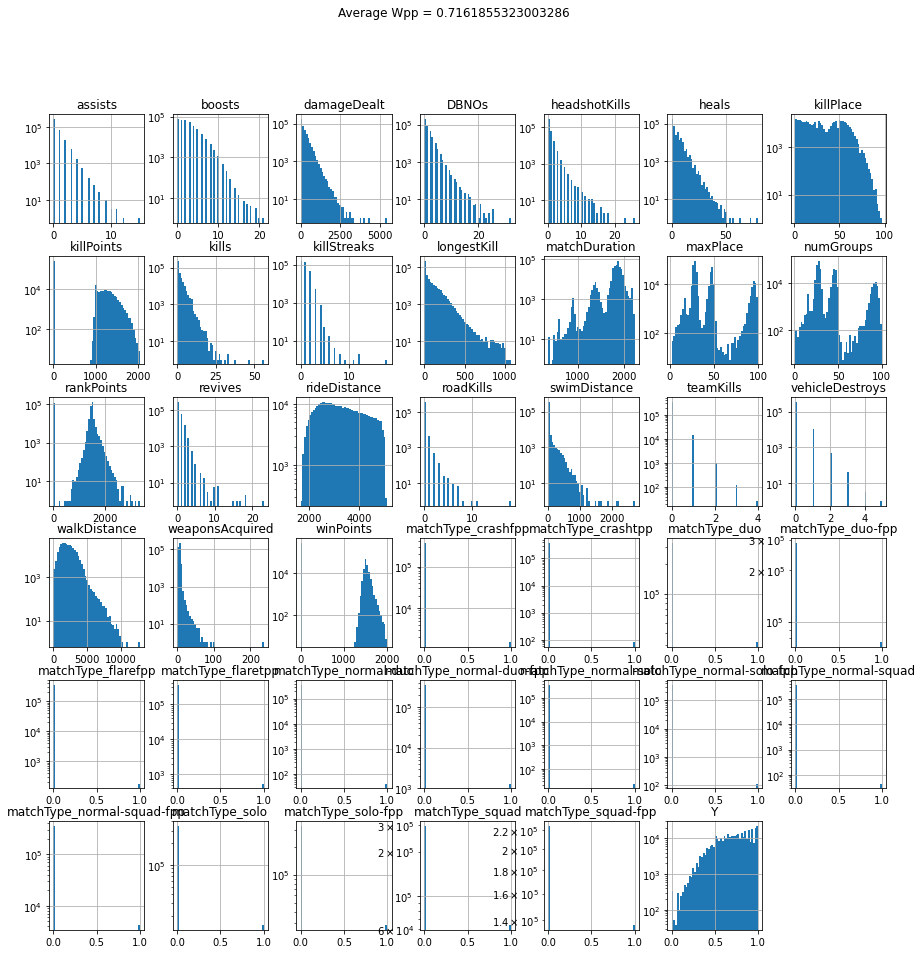

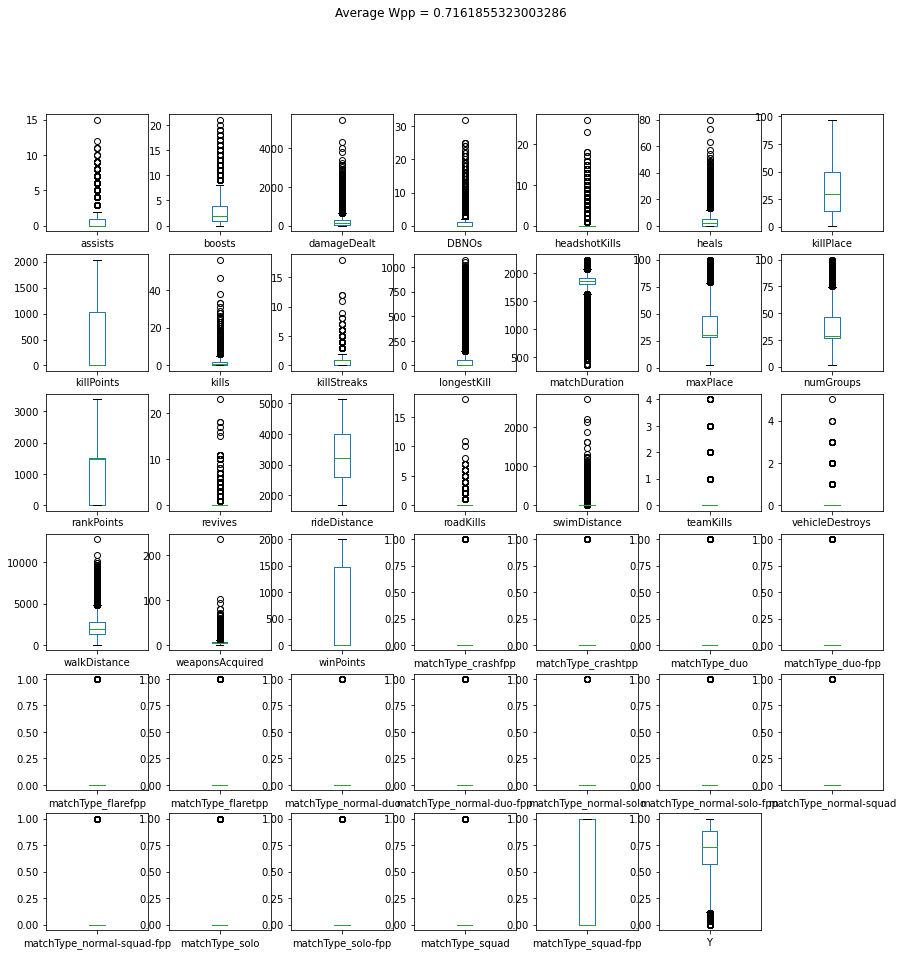

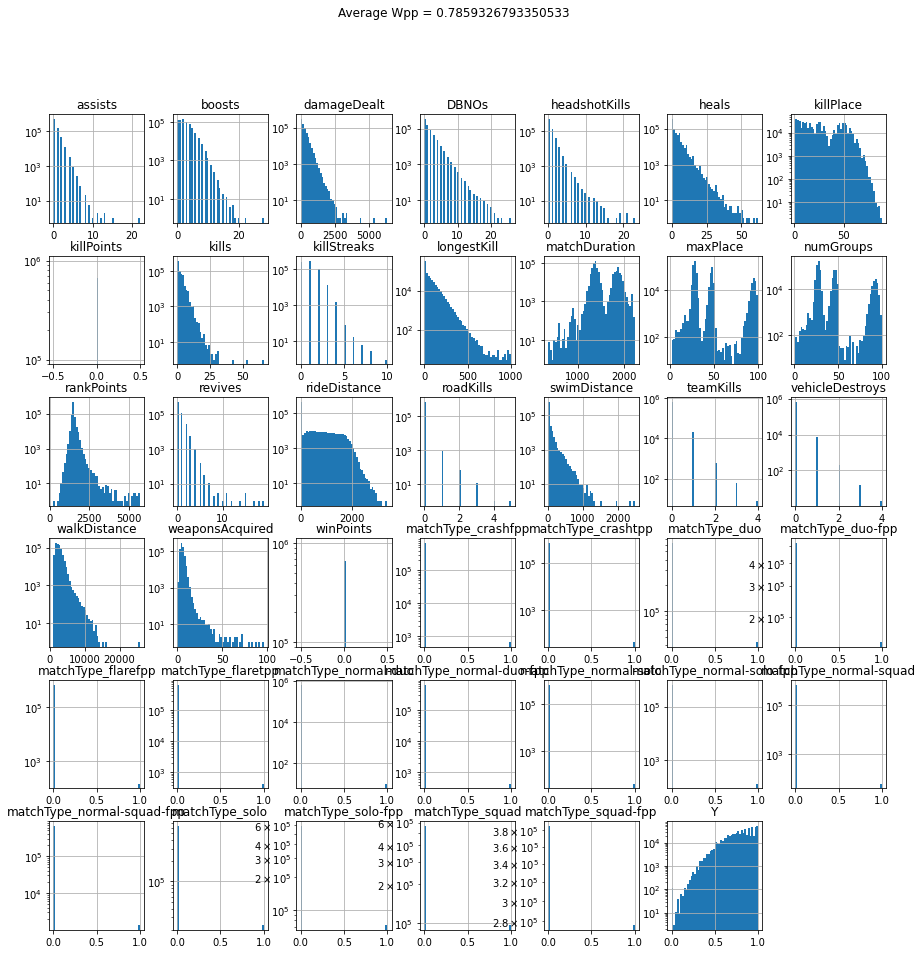

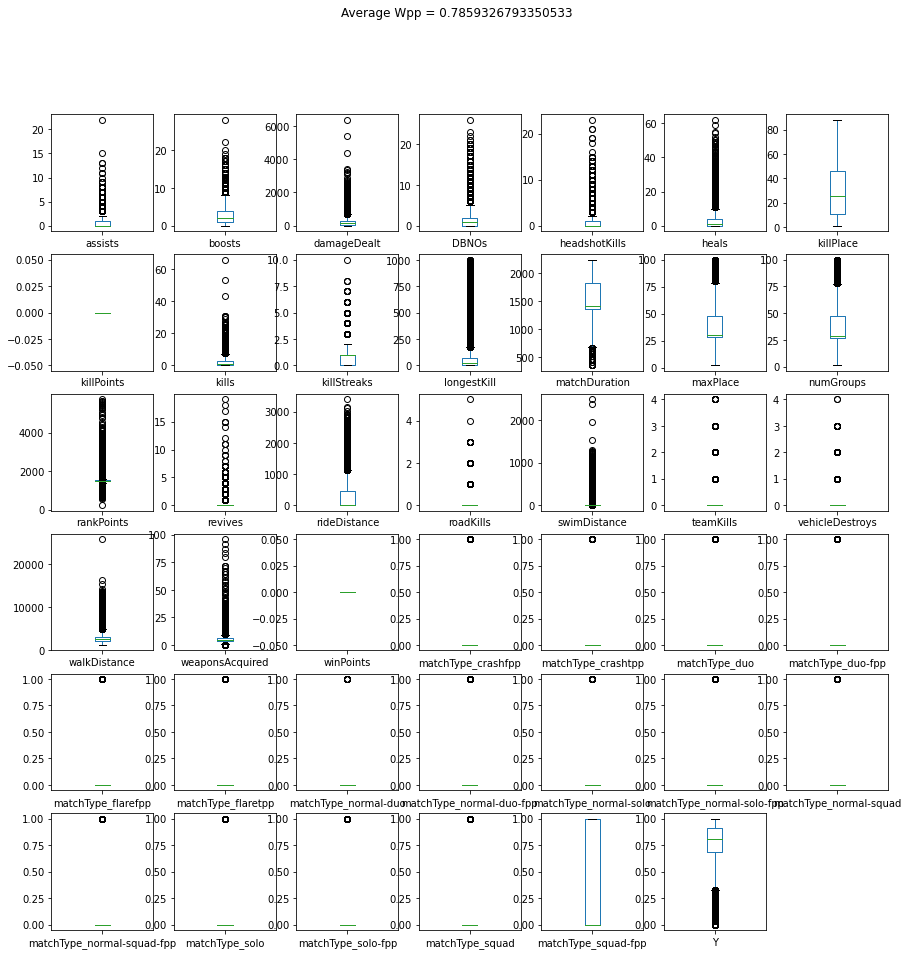

In [50]:
plot_distributions(X_train_temp,y_train_temp,6)

### View matchType statistics 

In [22]:
#Original dataset
matchTypes = pd.DataFrame({'counts': train_data.groupby(('matchType')).size(),
                             'Percentage': train_data.groupby(('matchType')).size() / len(train_data)})

<AxesSubplot:>

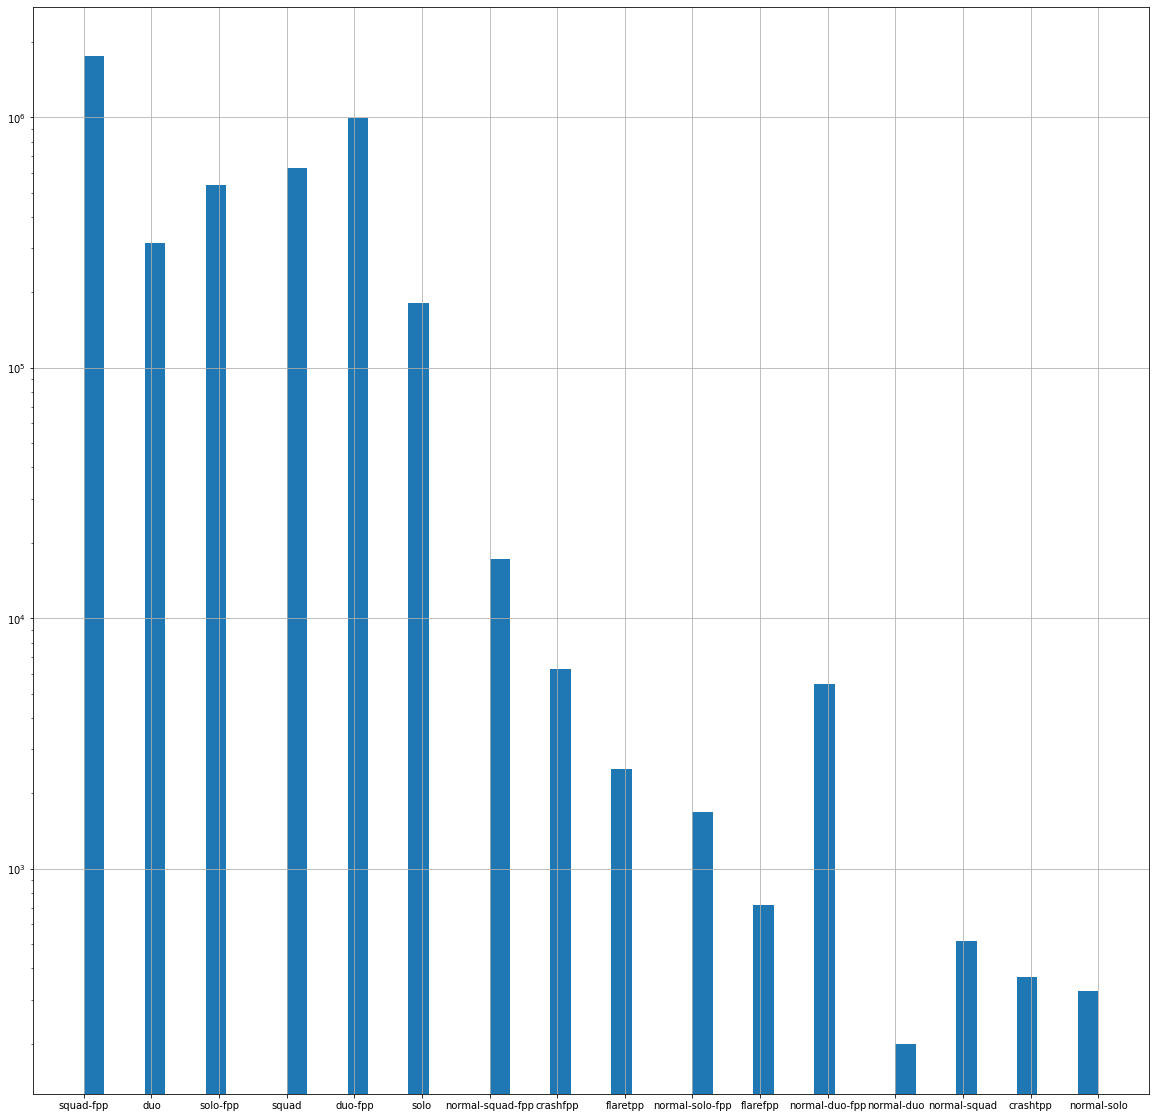

In [10]:
train['matchType'].astype('category').hist(bins=50,figsize=(20,20),log=True)

In [23]:
matchTypes

,counts,Percentage
matchType,,
crashfpp,6287,0.001414
crashtpp,371,0.000083
duo,313591,0.070518
duo-fpp,996691,0.224128
flarefpp,718,0.000161
flaretpp,2505,0.000563
normal-duo,199,0.000045
normal-duo-fpp,5489,0.001234
normal-solo,326,0.000073


### View the Average  WinPlacePerc for ranked and unranked

In [10]:
#Split ranked and unranked
search_values = ["normal","crash","flare"]
train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
train_normal = train[train.matchType.str.contains('|'.join(search_values))]

In [13]:
#Original dataset
Means = pd.DataFrame({'Mean': [train_rank["winPlacePerc"].mean(),train_normal["winPlacePerc"].mean()]})
Means

,Mean
0,0.472638
1,0.495746


### Plot Correlation Heat Map 
killPoints, matchDuration, maxPlace, numGroups, rankPoints, roadKills, teamKills, winPoints has no linear correlation to maxPlacePerc.

In [69]:
def plot_heat_map(X,y):
    dataset_ = pd.concat([X,y],axis=1)
    corr = dataset_.corr()
    plt.subplots(figsize=(30,20))
    sns.heatmap( corr, square=True, annot=True, fmt=".01f" )  
    plt.show()

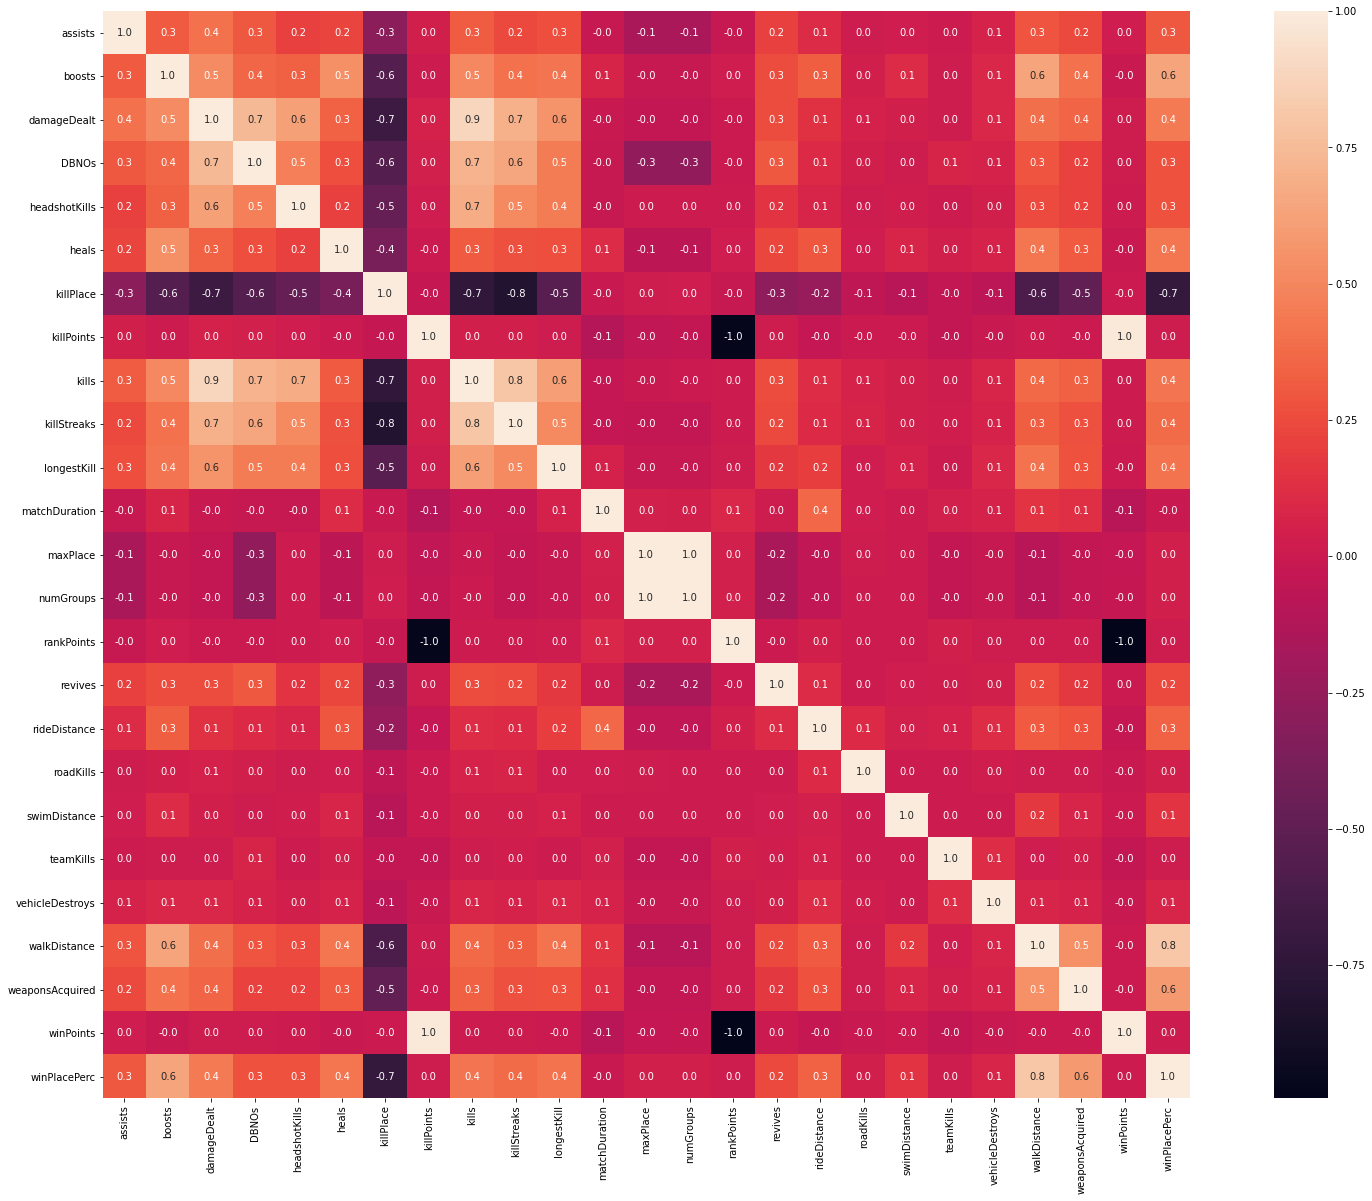

In [70]:
plot_heat_map(X_train,y_train)

### Split X and y value before preprocessing to make sure the consistency

In [16]:
#Randomly pick 80% samples as training set, 20% samples as test set
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.2,random_state = 200)

### Approach 1: 

1. Do One-Hot Encoding for "matchType"

In [17]:
def filter_1(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    return X_train_,X_test_

In [18]:
X_train_1,X_test_1 = filter_1(X_train,X_test)

### Approach 2: 

1.Delete inconsistent values such as rankPoints

2.Do One-Hot Encoding for "matchType"

In [19]:
def filter_2(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [20]:
X_train_2,X_test_2 = filter_2(X_train,X_test)

### Approach 3: 
1.Delete inconsistent values such as rankPoints

2.Combine ranked data with unranked data

3.Do One-Hot Encoding for "matchType"

In [21]:
def filter_3(X_train,X_test):
    
    X = pd.concat([X_train.copy(),X_test.copy()])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_ = X.drop(["rankPoints","killPoints","winPoints"],axis=1)

    X_ = X_.replace(["solo", "duo","squad","solo-fpp","duo-fpp", "squad-fpp"],
                    ["normal-solo","normal-duo", "normal-squad","normal-solo-fpp","normal-duo-fpp","normal-squad-fpp",])
    
    #Do One-Hot Encoding for "matchType"
    X_ = pd.get_dummies(data = X_, columns = ["matchType"])
    
    X_train_ = X_.head(X_train.shape[0])
    X_test_ = X_.tail(X_test.shape[0])
    
    return X_train_,X_test_

In [22]:
X_train_3,X_test_3 = filter_3(X_train,X_test)

### Approach 4:
1.Delete inconsistent values such as rankPoints

2.Split ranked data and unranked data (crash and flare are considered as unranked data)

3.Do One-Hot Encoding for "matchType"

In [23]:
def filter_4(X_train,X_test,y_train,y_test):
    
    train = pd.concat([X_train.copy(),y_train.copy()],axis=1)
    test = pd.concat([X_test.copy(),y_test.copy()],axis=1)
    
    #Split ranked and unranked
    search_values = ["normal","crash","flare"]
    train_rank = train[~train.matchType.str.contains('|'.join(search_values))]
    train_normal = train[train.matchType.str.contains('|'.join(search_values))]
    test_rank = test[~test.matchType.str.contains('|'.join(search_values))]
    test_normal = test[test.matchType.str.contains('|'.join(search_values))]

    #Split X and y
    y_train_rank = train_rank["winPlacePerc"]
    X_train_rank = train_rank.drop(["winPlacePerc"],axis=1)
    
    y_train_normal = train_normal["winPlacePerc"]
    X_train_normal = train_normal.drop(["winPlacePerc"],axis=1)
    
    y_test_rank = test_rank["winPlacePerc"]
    X_test_rank = test_rank.drop(["winPlacePerc"],axis=1)
    
    y_test_normal = test_normal["winPlacePerc"]
    X_test_normal = test_normal.drop(["winPlacePerc"],axis=1)
    
    #Concatenate
    X_rank = pd.concat([X_train_rank,X_test_rank])
    X_normal = pd.concat([X_train_normal,X_test_normal])
    
    #Delete inconsistent data : rankPoints, killPoints, winPoints
    X_rank = X_rank.drop(["rankPoints","killPoints","winPoints"],axis=1)
    X_normal = X_normal.drop(["rankPoints","killPoints","winPoints"],axis=1)
    
    #Do One-Hot Encoding for "matchType"
    X_rank = pd.get_dummies(data = X_rank, columns = ["matchType"])
    X_normal = pd.get_dummies(data = X_normal, columns = ["matchType"])
    
    #Split into train and test again
    X_rank_train_ = X_rank.head(X_train_rank.shape[0])
    X_rank_test_ = X_rank.tail(X_test_rank.shape[0])
    
    X_normal_train_ = X_rank.head(X_train_normal.shape[0])
    X_normal_test_ = X_rank.tail(X_test_normal.shape[0])    
    
    return X_rank_train_,y_train_rank,X_rank_test_,y_test_rank,X_normal_train_,y_train_normal,X_normal_test_,y_test_normal

In [24]:
X_train_rank,y_train_rank,X_test_rank,y_test_rank,X_train_normal,y_train_normal,X_test_normal,y_test_normal = filter_4(X_train,X_test,y_train,y_test)

# Initialize models

### Single Set
Use a list to store all models

In [32]:
n_approaches = 3

In [33]:
X_train_list = [X_train_1,X_train_2,X_train_3]
X_test_list = [X_test_1,X_test_2,X_test_3]

#### 1. SGDRegressor 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [34]:
sgds = [SGDRegressor()]*n_approaches

### Multiple Sets

In [35]:
sgd_rank = SGDRegressor()
sgd_normal = SGDRegressor()

# Training & Validation

### Single set 

In [29]:
losses = ["squared_loss",'huber','epsilon_insensitive','squared_spsilon_insensitive']
penalties = ['l2','l1','elasticnet']
max_iters = [1000,2000,3000]
learning_rates = ["invscaling",'constant','optimal','adaptive']

In [ ]:
for i in range(len(sgds)):
    sgd = sgds[i]
    best_loss = None
    best_penalty = None
    best_max_iter = None
    best_learning_rate = None
    best_score = 0
    for loss in losses:
        sgd.loss = loss
        for penalty in penalties:
            sgd.penalty = penalty
            for max_iter in max_iters:
                sgd.max_iter = max_iter
                for learning_rate in learning_rates:
                    sgd.learning_rate = learning_rate
                    scores = cross_val_score(sgd, X_train_list[i], y_train, cv=5,scoring = "neg_mean_absolute_error")
                    avg_score = sum(-scores)/5
                    if(avg_score>best_score):
                        best_score = avg_score
                        best_loss = loss
                        best_penalty = penalty
                        best_max_iter = max_iter
                        best_learning_rate = learning_rate
                    print("model: ",sgd, "score: ",avg_score)
    sgds[i].loss = best_loss
    sgds[i].penalty = best_penalty
    sgds[i].max_iter = best_max_iter
    sgds[i].learning_rate = best_learning_rate

### Multiple Sets

In [ ]:
sgd_rank = SGDRegressor()
sgd_normal = SGDRegressor()

# Results

In [71]:
sgds[0].fit(X_train_list[0],y_train)

SGDRegressor()

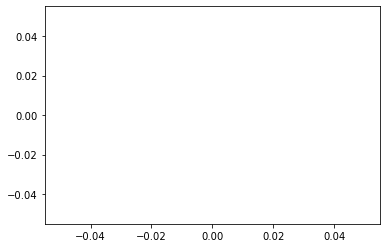

In [81]:
old_stdout = sys.stdout
sys.stdout = mystdout = StringIO()
sgds[0].fit(X_train_list[0],y_train)
sys.stdout = old_stdout
loss_history = mystdout.getvalue()
loss_list = []
for line in loss_history.split('\n'):
    if(len(line.split("loss: ")) == 1):
        continue
    loss_list.append(float(line.split("loss: ")[-1]))
plt.figure()
plt.plot(np.arange(len(loss_list)), loss_list)
plt.show()
plt.xlabel("Time in epochs")
plt.ylabel("Loss")
plt.close()

In [61]:
mean_absolute_error(sgds[0].predict(X_test_list[0]),y_test)

0.0926850056407578

In [62]:
sgds[1].fit(X_train_list[1],y_train)

SGDRegressor()

In [63]:
mean_absolute_error(sgds[1].predict(X_test_list[1]),y_test)

0.09292052467013884

In [64]:
sgds[2].fit(X_train_list[2],y_train)

SGDRegressor()

In [65]:
mean_absolute_error(sgds[2].predict(X_test_list[2]),y_test)

0.09315797468223638

In [69]:
sgd_rank.fit(X_train_rank,y_train_rank)
sgd_normal.fit(X_train_normal,y_train_normal)

SGDRegressor()

In [70]:
(mean_absolute_error(sgd_rank.predict(X_test_rank),y_test_rank)*X_test_rank.shape[0]+mean_absolute_error(sgd_normal.predict(X_test_normal),y_test_normal)*X_test_normal.shape[0])/(X_test_rank.shape[0]+X_test_normal.shape[0])

0.09320165415469985